In [78]:
## Config
MODEL_PATH="../resources/ckpts/lgb_v2"
MARKET_DATA_PATH="../resources/data/csi300_stock_feats.csv"
NEWS_DATA_DIR="../resources/data/CSI300news_chunked_summarized_senti"
PRED_OUPUT_DIR="results/股价预测_1910-12_lgb_v2"

In [28]:
## 初始化数据集
import polars as pl
import pandas as pd
import sys; sys.path.append("..")
from utils.models import *
from utils.alpha import *

def transform_data(df: pl.DataFrame):
    df = build_alpha158(df)
    df = build_label(df)
    return df

## 1
df = (pl
    .read_csv(MARKET_DATA_PATH)
    .filter(pl.col('datetime').str.strptime(pl.Datetime).dt.year() == 2019)
    .group_by('instrument')
    .map_groups(transform_data)
    .to_pandas()
)

df = df.assign(
    full_instrument=df['instrument'],
    datetime=pd.to_datetime(df['datetime']),
    instrument=df['instrument'].str.slice(start=2)
).set_index(['instrument', 'datetime'])

## 2
df_news = pd.concat([(pd
    .read_json(os.path.join(NEWS_DATA_DIR, filename))
    .assign(instrument=filename.split('.')[0],datetime=lambda x: x['date'].dt.date)
    )
    for filename in os.listdir(NEWS_DATA_DIR)
    if filename.endswith(".json")
], ignore_index=True)

df_senti = build_senti_alpha(df_news,method="概率均值")
df_senti = (df_senti
    .assign(datetime=pd.to_datetime(df_senti['datetime']))
    .fillna({'SENTI': 0})
    .set_index(['instrument', 'datetime'])
)

## 3
df_tot=pd.merge(df, df_senti, left_index=True, right_index=True, how='left')
df_tot.fillna({'SENTI':0}, inplace=True)

In [79]:
## 载入模型
import sys; sys.path.append("..")
from utils.models import *

model = BaseModel.use_subclass('lgb')()
model.load(MODEL_PATH)

In [80]:
## 预测
label_cols = ['LABEL0']
alpha158_cols = [col for col in df.columns if col.isupper() and col not in label_cols]
feature_cols = [col for col in df_tot.columns if col.isupper() and col not in label_cols] ## alpha158+senti
df_test = df_tot[df_tot.index.get_level_values('datetime').month.isin(range(10,13))]
df_predicted = model.pred(df_test, alpha158_cols)  # lgb: alpha158_cols, lgb+: alpha158_cols 

/mnt/disk2/xinghua.jia/workspace/finbot/eval/../utils/models.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predict'] = self.model.predict(df[feature_cols]).tolist()


In [81]:
## 回测
import numpy as np
import backtrader as bt

class MyPandasData(bt.feeds.PandasData):
    lines = ('predict',)
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('predict', 'predict')
    )


class MyStrategy(bt.Strategy):
    '''
    简化版策略：如果预测值为正且持仓少于2个股票，则买入预测值最大的股票。
    如果预测值为负，则卖出对应的股票。
    '''
    params=(
        ('lookback', 20),
        ('stopup', 0.22), 
        ('stopdown', 0.08),
    )
    
    def __init__(self):
        # 初始化交易指令和买入的股票列表
        self.order = None
        self.buy_list = []
        self.dates = []  # 用来记录每个时间点的日期
        self.portfolio_values = []  # 用来记录每个时间点的组合价值

    def next(self):
        # 每个时间点记录当前组合价值
        # print(f"{self.datas[0].datetime.date(0)} 组合当前价值: {self.broker.getvalue()}")
        self.dates.append(self.datas[0].datetime.date(0))
        self.portfolio_values.append(self.broker.get_value())  # 记录当前组合的净值
        
        if self.order:  # 如果有待执行的指令，直接返回
            return

        max_stocks = 4  # 每天最多持有4只股票

        # 遍历已经持有的股票，首先处理卖出信号
        for code in self.buy_list[:]:
            data = self.getdatabyname(code)
            if data.predict[0] < 0:
                # 卖出信号，预测为负，卖出持有的股票
                self.sell(data, size=self.position.size, name=code)
                self.buy_list.remove(code)  # 从买入列表中移除该股票

        # 按预测值选择买入股票
        buy_candidates = []
        for code in self.getdatanames():
            data = self.getdatabyname(code)
            if data.predict[0] > 0 and code not in self.buy_list:
                # 预测为正，且未持有该股票
                buy_candidates.append((data.predict[0], code))  # 保存预测值和股票代码

        # 按预测值从大到小排序
        buy_candidates.sort(reverse=True, key=lambda x: x[0])

        # 买入最多持有4只股票
        for _, code in buy_candidates[:max_stocks - len(self.buy_list)]:
            data = self.getdatabyname(code)
            price = data.close[0]
            if pd.isna(price) or price <= 0: continue
            
            order_value = self.broker.get_cash() * 0.25  # 使用现金的25%进行买入
            order_amount = int(order_value / price)  # 按照当前价格买入的数量
            self.buy(data, size=order_amount, name=code)
            self.buy_list.append(code)  # 记录买入的股票
        # print(self.buy_list,self.broker.get_cash(),self.broker.get_value())

# 创建Cerebro并添加数据
cerebro = bt.Cerebro()
all_dates = df_predicted.index.get_level_values(1).unique()
valid_instruments = []
for instrument, group in df_predicted.groupby('instrument'):
    instrument_dates = group.index.get_level_values(1).unique().unique()
    if not set(all_dates).issubset(set(instrument_dates)):continue  # 如果日期不全，跳过该股票
    if group['close'].isna().any():  continue # 如果存在 NaN 价格，跳过该股票
    valid_instruments.append(instrument)# 记录有效的股票

subdf_predicted = df_predicted[df_predicted.index.get_level_values(0).isin(valid_instruments)]

for instrument, group in subdf_predicted.groupby('instrument'):
    group = group.reset_index(level=0, drop=True)
    if len(group)<61: continue
    cerebro.adddata(MyPandasData(dataname=group), name=instrument)
cerebro.addstrategy(MyStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="SharpeRatio")
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="AnnualReturn")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="DrawDown")

cerebro.broker.set_cash(1e6) # 设定初始资金
cerebro.broker.setcommission(commission=6e-4) # 设定手续费万6

result = cerebro.run()

Sharpe Ratio: OrderedDict([('sharperatio', None)])
Annual Return: OrderedDict([(2019, 0.13847959659310338)])
Max Drawdown: AutoOrderedDict([('len', 26), ('drawdown', 6.161227480449088), ('moneydown', 68569.23586653336)])


/tmp/ipykernel_666311/1145714743.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


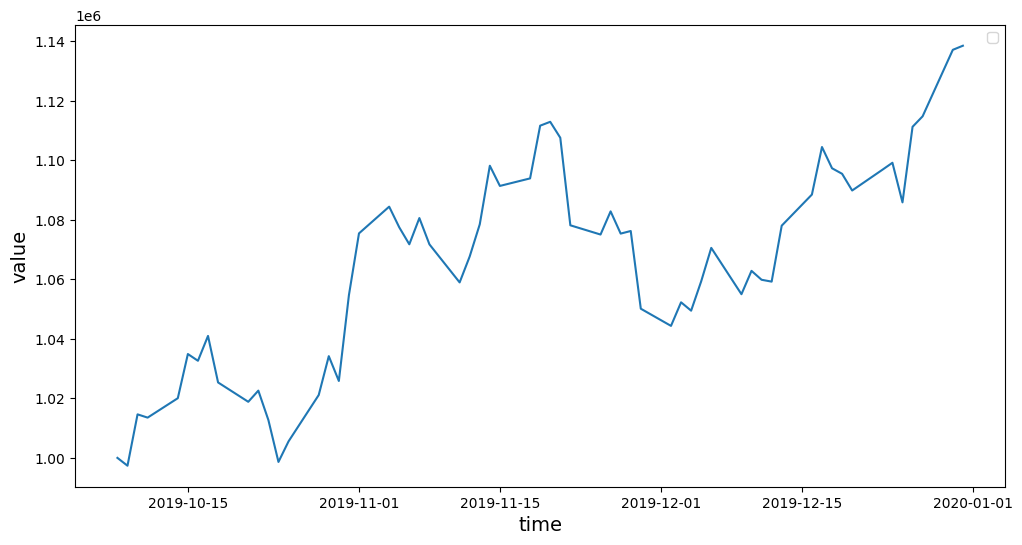

In [82]:
## 统计
import matplotlib.pyplot as plt
import json
%matplotlib inline

# 获取分析结果
sharpe_ratio = result[0].analyzers.SharpeRatio.get_analysis()
annual_return = result[0].analyzers.AnnualReturn.get_analysis()
drawdown = result[0].analyzers.DrawDown.get_analysis()

print("Sharpe Ratio:", sharpe_ratio)
print("Annual Return:", annual_return)
print("Max Drawdown:", drawdown['max'])

# 获取组合的净值曲线
dates = result[0].dates  # 获取日期
portfolio_values = result[0].portfolio_values

# 绘制净值曲线
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_values)  
plt.xlabel('time', fontsize=14)  
plt.ylabel('value', fontsize=14)  
plt.legend()
plt.show()

In [83]:
## 保存结果
os.makedirs(PRED_OUPUT_DIR,exist_ok=True)
subdf_predicted.drop(columns=alpha158_cols).to_excel(os.path.join(PRED_OUPUT_DIR,"result.xlsx"))

strategy_results = {
    'Sharpe Ratio': dict(sharpe_ratio),
    'Annual Return': dict(annual_return),
    'Max Drawdown': dict(drawdown['max']),
    'Date': [str(date) for date in dates],
    'Portfolio Value': portfolio_values
}

# 将字典保存为 JSON 文件
with open(os.path.join(PRED_OUPUT_DIR,'strategy_results.json'), 'w') as json_file:
    json.dump(strategy_results, json_file, ensure_ascii=False, indent=4)
